In [3]:
import numpy as np
from astropy.table import Table, Column
from numpy import random
import scipy.stats as stats
import matplotlib.pyplot as plt
import astropy.coordinates as coords
import astropy.units as u

In [4]:
bO = Table.read('EAFullCDGS.fits')
origx = bO['GAIA X']/1000
origy = bO['GAIA Y']/1000
origz = bO['GAIA Z']/1000
radius_cylindrical_orig = ((origx**2 + origy**2)**0.5)
radiusxyz_orig = bO['GAIA RADIUS']/1000
origAM = bO['ALPHA/M']
origAMError = bO['ALPHA ERROR']

rows = len(origx)
bO.info

<Table length=43028>
       name         dtype 
------------------ -------
ID - GOLD STANDARD bytes18
     APOGEE RADIUS float64
          APOGEE X float64
          APOGEE Y float64
          APOGEE Z float64
       GAIA RADIUS float64
            GAIA X float64
            GAIA Y float64
            GAIA Z float64
           GAIA RA float64
          GAIA DEC float64
          DISTANCE float64
            DISTLO float64
            DISTHI float64
           DISTLEN float64
           ALPHA/M float64
       ALPHA ERROR float64
              FE/H float64
        FE/H ERROR float64
             LOG G float64
       LOG G ERROR float64
       TEMPERATURE float64
        TEMP ERROR float64

In [5]:
def create_new_distance(rows, n, distance, lowsigma, hisigma, nval = 1000):
    new_distance_bin = np.zeros(shape=(rows,n))
    for i, (mymean, myclipa, myclipb) in enumerate(zip(distance, lowsigma, hisigma)):
        STD1 = myclipb-myclipa
        a = (myclipa - mymean)/STD1
        b = (myclipb - mymean)/STD1
        mean, var, skew, kurt = stats.truncnorm.stats(a, b, moments='mvsk')
        for j in range(0,n):            
            X = stats.truncnorm(a, b, loc=mymean, scale=STD1)            
            new_dist = X.rvs(nval)[random.randint(nval)]
            new_distance_bin[i,j] = new_dist
    return new_distance_bin

In [6]:
xval = np.arange(-1, 1, 0.05)
m = -0.05
c = 0.08
yval = m*xval + c
avg = np.mean(yval)

##It's an arbitrary number is the correct answer, don't worry about pinning down an exact figure

minRadius = np.arange(0, 15, 2)
maxRadius = np.arange(2, 17, 2)
minZheights = [0.0, 0.5, 1.0]
maxZheights = [0.5, 1.0, 2.0]

print(minRadius, maxRadius)

[ 0  2  4  6  8 10 12 14] [ 2  4  6  8 10 12 14 16]


In [7]:
n = 1000

currentIndex = 0
zcoord = np.zeros((rows, n))
radius = np.zeros((rows, n))
cr = np.zeros((rows, n))
height = np.zeros((rows, n))
alpha = np.zeros((rows))


binNumbers = np.arange(8)
for bN in binNumbers:
    filename = 'EABin{0}CDGS.fits'.format(bN+1)
    b = Table.read(filename)
    DLO = b['DISTLO']
    DHI = b['DISTHI']
    DIST = b['DISTANCE']
    RAD = b['GAIA RADIUS']
    RA = (b['GAIA RA'])*u.deg
    DEC = (b['GAIA DEC'])*u.deg
    AM = b['ALPHA/M']
    AME = b['ALPHA ERROR']
    ID = b['ID - GOLD STANDARD']
    currentrows = len(AM)

    distance_bin = create_new_distance(currentrows, n, DIST, DLO, DHI)
    a = currentIndex
    z = currentIndex + currentrows
    print(a,z)
    print(len(AM))
    alpha[a:z] = AM
    for i in range(n):
        GC = coords.SkyCoord(RA, DEC, distance_bin[:,i]/1000.*u.kpc)
        GCGAL = GC.transform_to(coords.Galactocentric)
        GX = GCGAL.x
        GY = GCGAL.y
        GZ = GCGAL.z

        radius[a:z, i] = ((GX**2 + GY**2 + GZ**2)**0.5)/u.kpc
        cr[a:z, i] = ((GX**2 + GY**2)**0.5)/u.kpc
        height[a:z, i] = GZ/u.kpc
    currentIndex += currentrows    



0 28
28
28 185
157
185 1189
1004
1189 6017
4828
6017 21046
15029
21046 36107
15061
36107 42193
6086
42193 42970
777


In [8]:
cr

array([[0.32279046, 1.48136028, 1.55470186, ..., 2.19983139, 2.58213715,
        1.43811409],
       [3.00778565, 0.96249108, 2.71552448, ..., 2.29651643, 1.35028284,
        1.59096963],
       [1.9565824 , 0.11137771, 2.54747429, ..., 0.70699081, 0.47119648,
        0.53359641],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [10]:
txyz = Table(radius)
txyz.write('MCAlphaRadiusXYZFull.csv')
tcr = Table(cr)
tcr.write('MCAlphaRadiusCylFull.csv')
tzval = Table(height)
tzval.write('MCAlphaHeightsFull.csv')

In [ ]:
##csv file format as fits does not support tables with 1000 columns :(

##Now that this is running correctly, let's do runs for all of the other elements and start getting ratios for all of them!!

##If you want to mess with the plots some more just read in the above tables, do not generate new numbers as each
##run of 1000 will take around 6 hours!!!

0 2
The mean and std is:  7.264659543969103 2.4563118490466618
2 4
The mean and std is:  4.506868833388657 0.6083038517362747
4 6
The mean and std is:  1.4582454757884242 0.037151738968439346
6 8
The mean and std is:  0.9641973537724098 0.004998229543333126
8 10
The mean and std is:  0.28007795088053367 0.0010251588271787677
10 12
The mean and std is:  0.1520479733737613 0.001246449926512936
12 14
The mean and std is:  0.1556431536895543 0.0030494583982428073
14 16
The mean and std is:  0.14578495801235022 0.00936772942226594


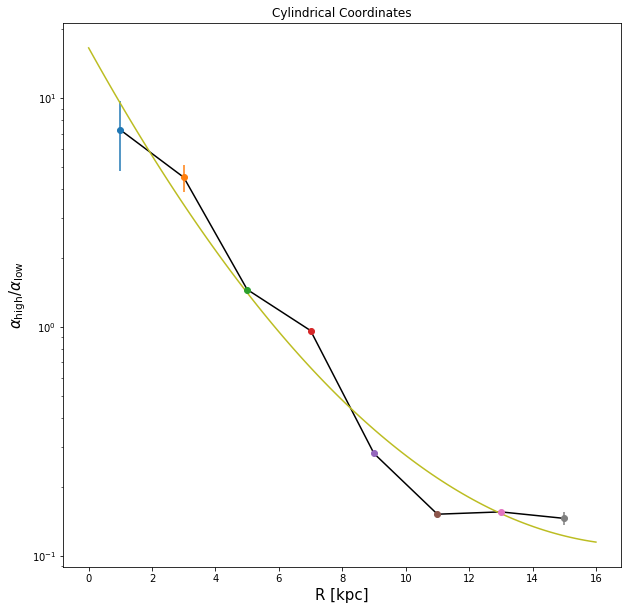

In [16]:
mean_ratio_alpha = []
std_ratio_alpha = []

plt.figure(figsize=(10,10))
for i, (minr, maxr) in enumerate(zip(minRadius, maxRadius)):
    ratio_alpha = np.zeros(n)
    for i, mcn in enumerate(np.arange(n)):
        if i == 0: print(minr, maxr)
        index_cr = np.logical_and( cr[:,mcn] > minr, cr[:,mcn] <= maxr)
        high_alpha_index = (alpha > avg) & index_cr
        low_alpha_index = (alpha <= avg) & index_cr

        nlow_alpha = np.sum(low_alpha_index)
        nhigh_alpha = np.sum(high_alpha_index)
        ratio_alpha[i] = float(nhigh_alpha)/nlow_alpha
        
    print('The mean and std is: ',np.mean(ratio_alpha), np.std(ratio_alpha))
    mean_ratio_alpha.append(np.mean(ratio_alpha))
    std_ratio_alpha.append(np.std(ratio_alpha))
    plt.errorbar(0.5*(minr + maxr), np.mean(ratio_alpha), yerr=np.std(ratio_alpha), fmt='o')
plt.plot(0.5*(minRadius + maxRadius), mean_ratio_alpha, c='k')
p = np.poly1d(np.polyfit(0.5*(minRadius + maxRadius), np.log10(mean_ratio_alpha), 2))
x = np.linspace(0, 16, 100)
plt.plot(x, 10**p(x))
plt.yscale('log')
plt.xlabel('R [kpc]', fontsize=15)
plt.ylabel(r'$\alpha_{\mathrm{high}}/\alpha_{\mathrm{low}}$', fontsize=15)
plt.title('Cylindrical Coordinates')
plt.savefig('alphaHighLowCylMCBF.png')

0 2
The mean and std is:  4.408526427494075 1.864393492654043
2 4
The mean and std is:  3.58690592931862 0.48666844925842423
4 6
The mean and std is:  1.2833670491434006 0.03410065422562085
6 8
The mean and std is:  0.8548491791307559 0.004767046273837239
8 10
The mean and std is:  0.3159117303626529 0.001083115521615636
10 12
The mean and std is:  0.1595420509263255 0.0012830957341555746
12 14
The mean and std is:  0.16064254890788662 0.003053535400963631
14 16
The mean and std is:  0.1486959552976241 0.009360298400143463


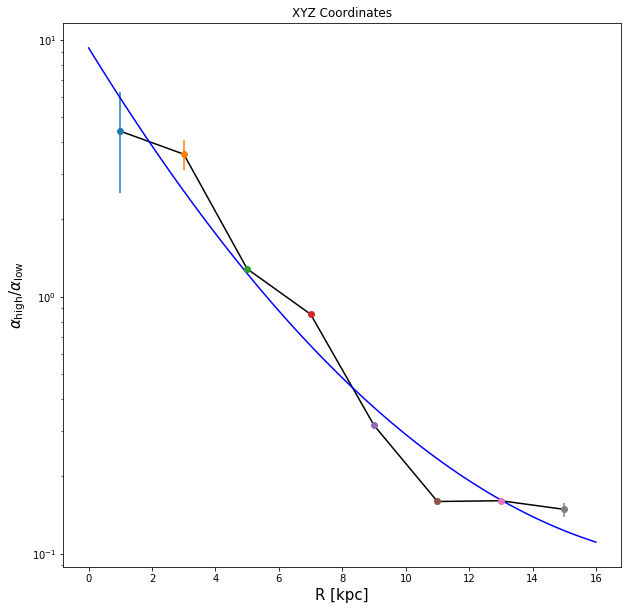

In [18]:
mean_xyzratio_alpha = []
std_xyzratio_alpha = []

plt.figure(figsize=(10,10))
for i, (minr, maxr) in enumerate(zip(minRadius, maxRadius)):
    ratio_alpha = np.zeros(n)
    for i, mcn in enumerate(np.arange(n)):
        if i == 0: print(minr, maxr)
        index_xyzr = np.logical_and( radius[:,mcn] > minr, radius[:,mcn] <= maxr)
        high_alpha_index = (alpha > avg) & index_xyzr
        low_alpha_index = (alpha <= avg) & index_xyzr

        nlow_alpha = np.sum(low_alpha_index)
        nhigh_alpha = np.sum(high_alpha_index)
        ratio_alpha[i] = float(nhigh_alpha)/nlow_alpha
        
    print('The mean and std is: ',np.mean(ratio_alpha), np.std(ratio_alpha))
    mean_xyzratio_alpha.append(np.mean(ratio_alpha))
    std_xyzratio_alpha.append(np.std(ratio_alpha))
    plt.errorbar(0.5*(minr + maxr), np.mean(ratio_alpha), yerr=np.std(ratio_alpha), fmt='o')
plt.plot(0.5*(minRadius + maxRadius), mean_xyzratio_alpha, c='k')
p = np.poly1d(np.polyfit(0.5*(minRadius + maxRadius), np.log10(mean_xyzratio_alpha), 2))
x = np.linspace(0, 16, 100)
plt.plot(x, 10**p(x), c='b')
plt.yscale('log')
plt.xlabel('R [kpc]', fontsize=15)
plt.ylabel(r'$\alpha_{\mathrm{high}}/\alpha_{\mathrm{low}}$', fontsize=15)
plt.title('XYZ Coordinates')
plt.savefig('alphaHighLowXYZMCBF.png')



0 2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


0.3333333333333333 69
The mean and std is:  inf nan
0 2


/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


7.0 69
The mean and std is:  inf nan
0 2
7.75 69
The mean and std is:  inf nan
2 4
0.3793103448275862 198
The mean and std is:  0.3419342341814942 0.09596114269008817
2 4
5.166666666666667 198
The mean and std is:  inf nan
2 4
28.5 198
The mean and std is:  inf nan
4 6
0.26184538653366585 1125
The mean and std is:  0.2794735705382457 0.01551008553428711
4 6
5.2439024390243905 1125
The mean and std is:  4.86708436357906 0.4188166627475521
4 6
17.0 1125
The mean and std is:  21.77822784992785 4.026665108316321
6 8
0.15485168426344897 5283
The mean and std is:  0.1515096533755691 0.00291461728298991
6 8
1.006276150627615 5283
The mean and std is:  0.9834307618853341 0.019055227806504888
6 8
6.15625 5283
The mean and std is:  6.428110322160884 0.1831551632348461
8 10
0.07576487593351 14521
The mean and std is:  0.0764316535159476 0.0008067929194497713
8 10
0.34003281378178835 14521
The mean and std is:  0.3425522545884937 0.0036843987079208883
8 10
1.8974854932301741 14521
The mean and std

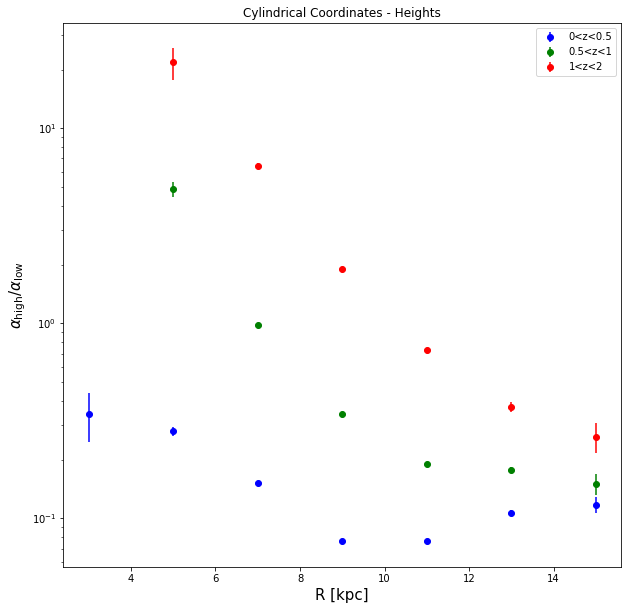

In [24]:
plt.figure(figsize=(10,10))
zbincolors = ["blue", "green", "red"]
zbinnames = ["0<z<0.5", "0.5<z<1", "1<z<2"]
mean_zcratio_alpha = []
std_zcratio_alpha = []
for i, (minr, maxr) in enumerate(zip(minRadius, maxRadius)):
    ratio_alpha = np.zeros(n)
    for i, (minz, maxz, cz) in enumerate(zip(minZheights, maxZheights, zbincolors)):
        for i, mcn in enumerate(np.arange(n)):
            if i == 0: print(minr, maxr)
            
            index_cr = np.logical_and( cr[:,mcn] > minr, cr[:,mcn] <= maxr)


            index_crz = np.logical_and(np.abs(height[:,mcn]) > minz, np.abs(height[:,mcn]) <= maxz)

            high_alpha_index = (alpha > avg) & index_cr & index_crz
            low_alpha_index = (alpha <= avg) & index_cr & index_crz

            nlow_alpha = np.sum(low_alpha_index)
            nhigh_alpha = np.sum(high_alpha_index)
            ratio_alpha[i] = float(nhigh_alpha)/nlow_alpha
        print(ratio_alpha[i], np.sum(index_cr))
        print('The mean and std is: ',np.mean(ratio_alpha), np.std(ratio_alpha))
        mean_zcratio_alpha.append(np.mean(ratio_alpha))
        std_zcratio_alpha.append(np.std(ratio_alpha))
        plt.errorbar(0.5*(minr + maxr), np.mean(ratio_alpha), yerr=np.std(ratio_alpha), fmt='o', c=cz)
z1 = mean_zcratio_alpha[0:8]
z2 = mean_zcratio_alpha[9:17]
z3 = mean_zcratio_alpha[17:25]
print("Ratios at 0<z<0.5 are:", z1)
print("Ratios at 0.5<z<1 are:", z2)
print("Ratios at 1<z<2 are:", z3)

plt.yscale('log')
plt.xlabel('R [kpc]', fontsize=15)
plt.ylabel(r'$\alpha_{\mathrm{high}}/\alpha_{\mathrm{low}}$', fontsize=15)
plt.title("Cylindrical Coordinates - Heights")
plt.legend(zbinnames)




0 2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


0.0 33
The mean and std is:  inf nan
0 2


/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


3.0 33
The mean and std is:  inf nan
0 2
inf 33
The mean and std is:  inf nan
2 4
0.3225806451612903 176
The mean and std is:  0.3358069733630963 0.09396059372132914
2 4
8.0 176
The mean and std is:  inf nan
2 4
8.333333333333334 176
The mean and std is:  inf nan
4 6
0.2962962962962963 1005
The mean and std is:  0.27990895465516547 0.01543968482059501
4 6
4.690476190476191 1005
The mean and std is:  4.935544240189774 0.4402236388845585
4 6
28.666666666666668 1005
The mean and std is:  25.41751984126984 5.702608283368615
6 8
0.15202020202020203 4786
The mean and std is:  0.1518773361703378 0.003062735282414348
6 8
1.020501138952164 4786
The mean and std is:  1.015473246790482 0.021288760172089905
6 8
7.008130081300813 4786
The mean and std is:  6.942046387545062 0.22421908229161233
8 10
0.0773109243697479 14964
The mean and std is:  0.07675679819663049 0.0008199333885881741
8 10
0.3573200992555831 14964
The mean and std is:  0.35090761651107844 0.0037299146372303904
8 10
2.0439770554493

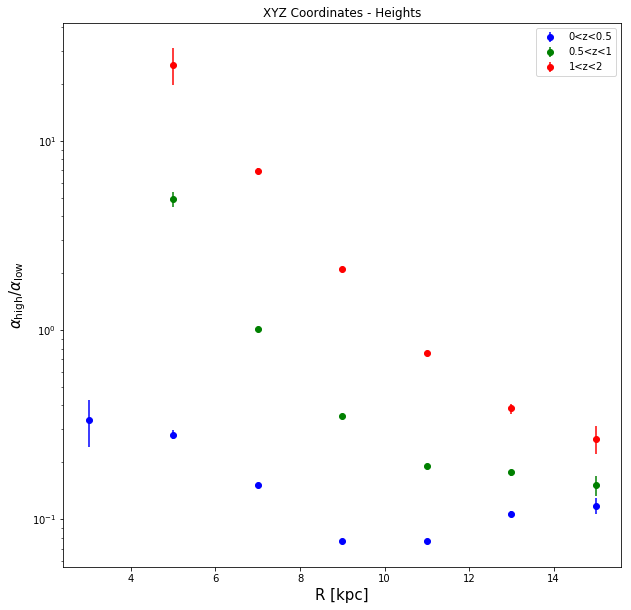

In [14]:
plt.figure(figsize=(10,10))
zbincolors = ["blue", "green", "red"]
zbinnames = ["0<z<0.5", "0.5<z<1", "1<z<2"]
for i, (minr, maxr) in enumerate(zip(minRadius, maxRadius)):
    ratio_alpha = np.zeros(n)
    for i, (minz, maxz, cz, zname) in enumerate(zip(minZheights, maxZheights, zbincolors, zbinnames)):
        for i, mcn in enumerate(np.arange(n)):
            if i == 0: print(minr, maxr)
            index_xyzr = np.logical_and( radius[:,mcn] > minr, radius[:,mcn] <= maxr)


            index_xyzrz = np.logical_and(np.abs(height[:,mcn]) > minz, np.abs(height[:,mcn]) <= maxz)

            high_alpha_index = (alpha > avg) & index_xyzr & index_xyzrz
            low_alpha_index = (alpha <= avg) & index_xyzr & index_xyzrz

            nlow_alpha = np.sum(low_alpha_index)
            nhigh_alpha = np.sum(high_alpha_index)
            ratio_alpha[i] = float(nhigh_alpha)/nlow_alpha
        print(ratio_alpha[i], np.sum(index_xyzr))
        print('The mean and std is: ',np.mean(ratio_alpha), np.std(ratio_alpha))
        plt.errorbar(0.5*(minr + maxr), np.mean(ratio_alpha), yerr=np.std(ratio_alpha), fmt='o', c=cz, label=zname)

plt.yscale('log')
plt.xlabel('R [kpc]', fontsize=15)
plt.ylabel(r'$\alpha_{\mathrm{high}}/\alpha_{\mathrm{low}}$', fontsize=15)
plt.title("XYZ Coordinates - Heights")
plt.legend(["0<z<0.5", "0.5<z<1", "1<z<2"])
plt.savefig('AlphaHighLowCylXYZZHeights1000.png')

In [63]:


for i, (minr, maxr) in enumerate(zip(minRadius, maxRadius)):
    ratio_alpha = np.zeros(0)

    index_cr = np.logical_and( radius_cylindrical_orig[:] > minr, radius_cylindrical_orig[:] <= maxr)
    high_alpha_index = (alpha > avg) & index_cr
    low_alpha_index = (alpha <= avg) & index_cr

    nlow_alpha = np.sum(low_alpha_index)
    nhigh_alpha = np.sum(high_alpha_index)
    ratio_alpha = np.append(ratio_alpha, float(nhigh_alpha)/nlow_alpha)
    print(ratio_alpha)


[0.06122449]
[0.0867052]
[0.15154639]
[0.15654054]
[0.25788609]
[0.35775236]
[0.34478886]
[0.30993151]


Text(0.5,1,'Cylindrical Coordinates - Original')

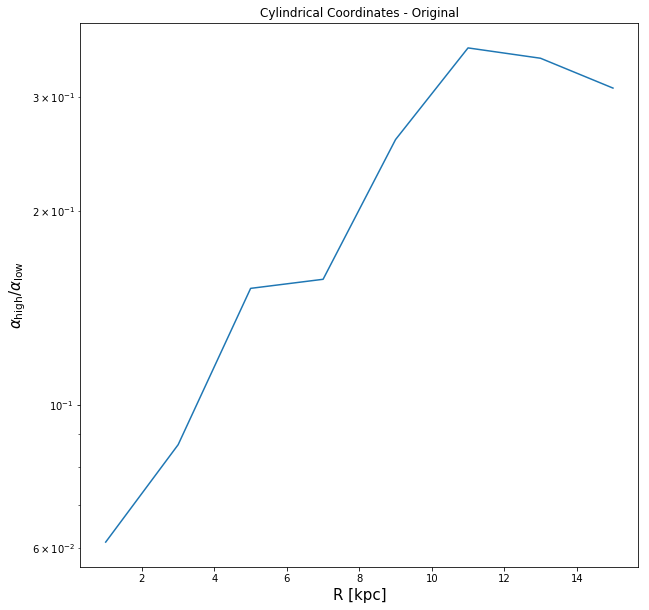

In [64]:
ratio_alpha = [0.06122449, 0.0867052, 0.15154639, 0.15654054, 0.25788609, 0.35775236, 0.34478886, 0.30993151]
plt.figure(figsize=(10,10))
plt.plot(0.5*(minRadius + maxRadius), ratio_alpha)
plt.yscale('log')
plt.xlabel('R [kpc]', fontsize=15)
plt.ylabel(r'$\alpha_{\mathrm{high}}/\alpha_{\mathrm{low}}$', fontsize=15)
plt.title('Cylindrical Coordinates - Original')

In [49]:
radius_cylindrical_orig

11.331452202048293
10.942462556422468
13.521429897929695
9.574255225059662
8.689583909576863
10.225835116982674
10.985789869851235
11.886409200622216
9.727226913710423
10.416940381665828
11.144499540966653


In [69]:
print(original_xyzratiob)

[0, 8.4000000000000004, 5.5384615384615383, 1.0274599542334095, 0.34999999999999998, 0.19223590892123926, 0.18525641025641026, 0.13777777777777778]


In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
ax = plt.subplot()
plt.title('Ratio of High/Low '+r'$\alpha$'+' in Each Galactic Radius', fontsize='18')
plt.xlabel('Galactic Radius', fontsize='16')
plt.ylabel('Number of High '+r'$\alpha$'+' Stars/Number of Low '+r'$\alpha$'+' Stars', fontsize='16')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')

LZ = plt.plot(r, original_xyzratioa, label='0<z<0.5', linestyle='dashdot', lw=3, c='g')
AZ = plt.plot(r, original_ratio, label='all z', lw=4, c='k')
HZ = plt.plot(r, original_xyzratioc, label='1<z<2', linestyle='dashed', lw=3, c='r')

plt.legend(fontsize='x-large')
plt.savefig('HighLowRatioforposter7.png')

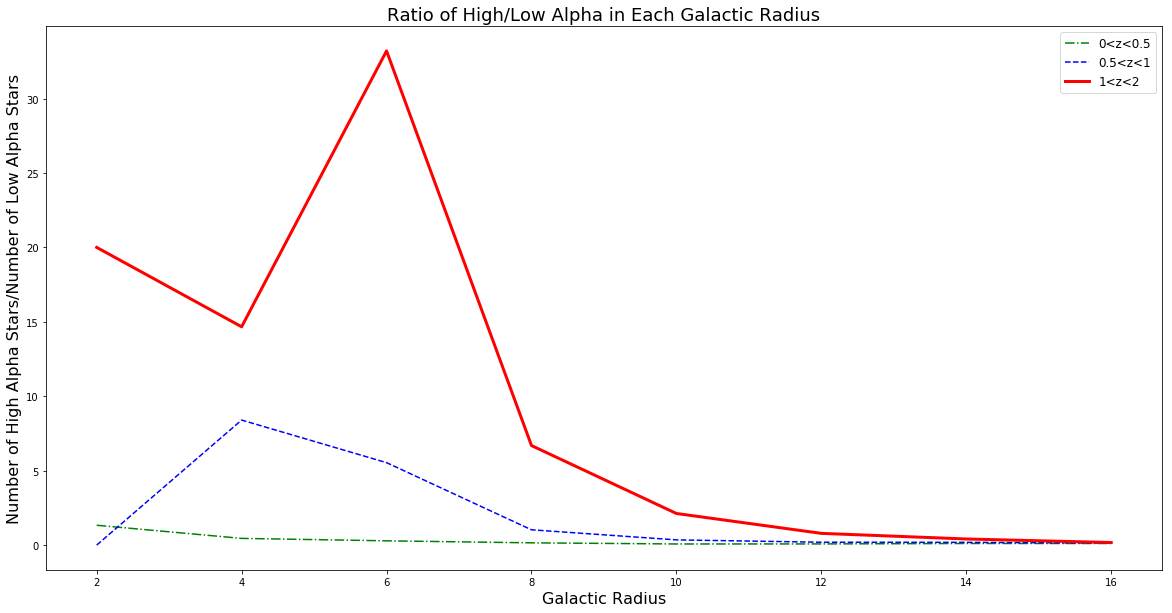

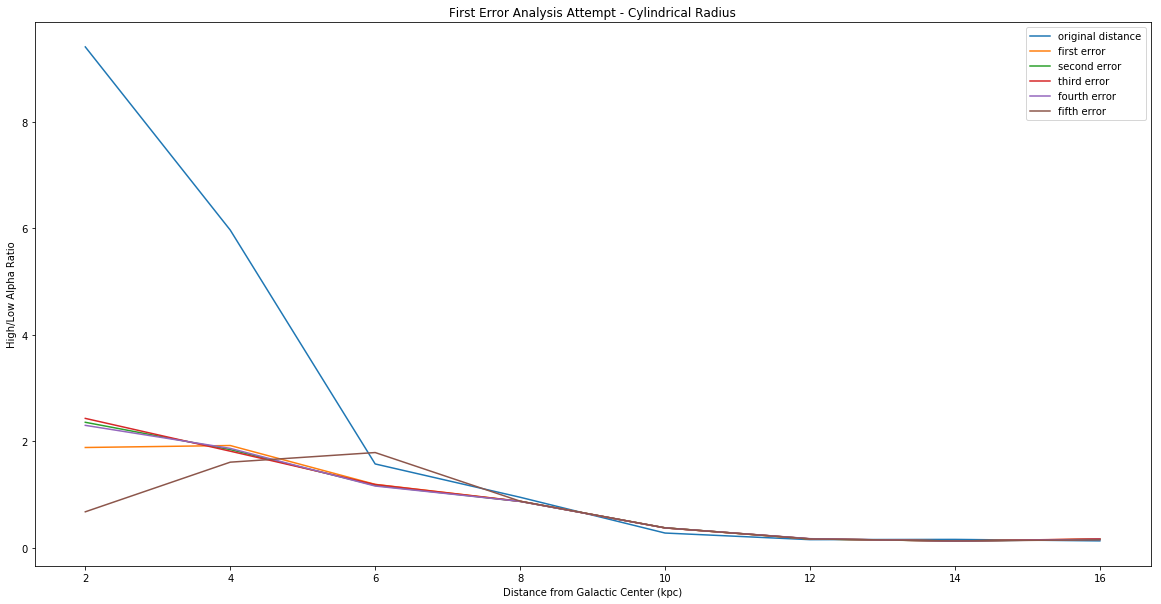

In [92]:

plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.title('First Error Analysis Attempt - Cylindrical Radius')
plt.xlabel('Distance from Galactic Center (kpc)')
plt.ylabel('High/Low Alpha Ratio')
orig = plt.plot(r, original_ratio, label='original distance')
try1 = plt.plot(r, try1_ratio, label='first error')
try2 = plt.plot(r, try2_ratio, label='second error')
try3 = plt.plot(r, try3_ratio, label='third error')
try4 = plt.plot(r, try4_ratio, label='fourth error')
try5 = plt.plot(r, try5_ratio, label='fifth error')
plt.legend()
plt.show()

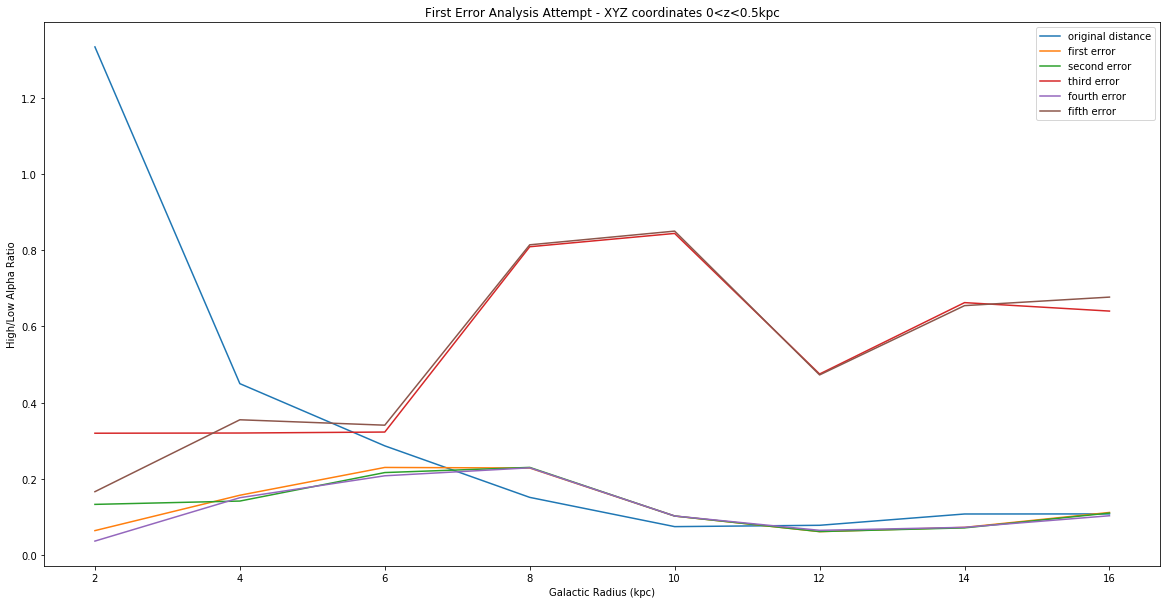

In [82]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.title('First Error Analysis Attempt - XYZ coordinates 0<z<0.5kpc')
plt.xlabel('Galactic Radius (kpc)')
plt.ylabel('High/Low Alpha Ratio')
xyzoriga = plt.plot(r, original_xyzratioa, label='original distance')
xyztry1a = plt.plot(r, try1_xyzratioa, label='first error')
xyztry2a = plt.plot(r, try2_xyzratioa, label='second error')
xyztry3a = plt.plot(r, try3_xyzratioa, label='third error')
xyztry4a = plt.plot(r, try4_xyzratioa, label='fourth error')
xyztry5a = plt.plot(r, try5_xyzratioa, label='fifth error')
plt.legend()
plt.show()

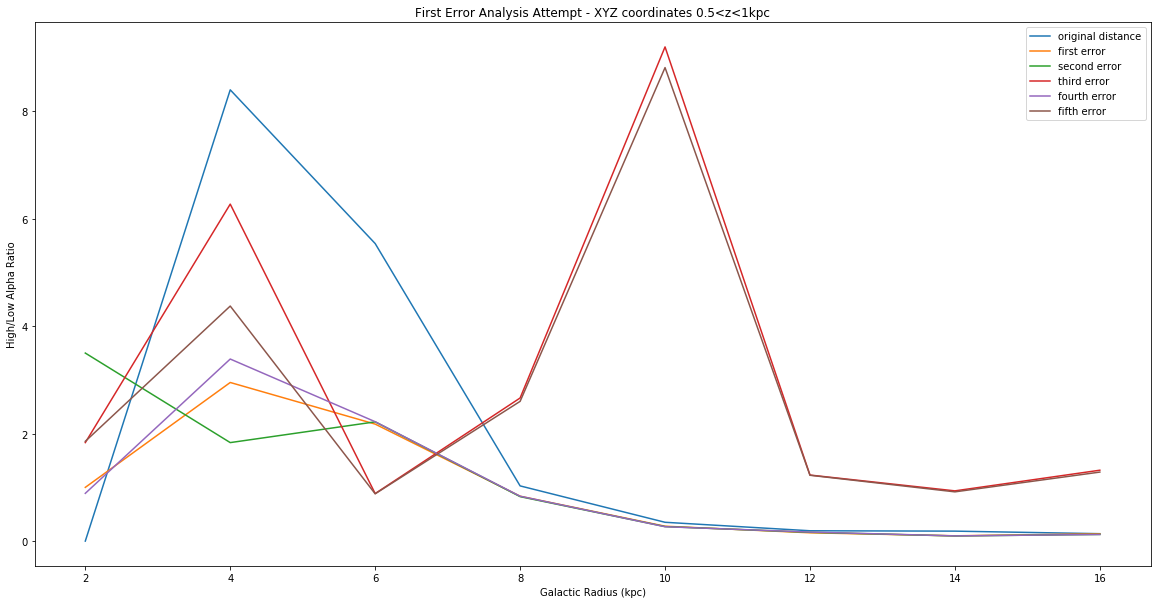

In [83]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.title('First Error Analysis Attempt - XYZ coordinates 0.5<z<1kpc')
plt.xlabel('Galactic Radius (kpc)')
plt.ylabel('High/Low Alpha Ratio')
xyzorigb = plt.plot(r, original_xyzratiob, label='original distance')
xyztry1b = plt.plot(r, try1_xyzratiob, label='first error')
xyztry2b = plt.plot(r, try2_xyzratiob, label='second error')
xyztry3b = plt.plot(r, try3_xyzratiob, label='third error')
xyztry4b = plt.plot(r, try4_xyzratiob, label='fourth error')
xyztry5b = plt.plot(r, try5_xyzratiob, label='fifth error')
plt.legend()
plt.show()

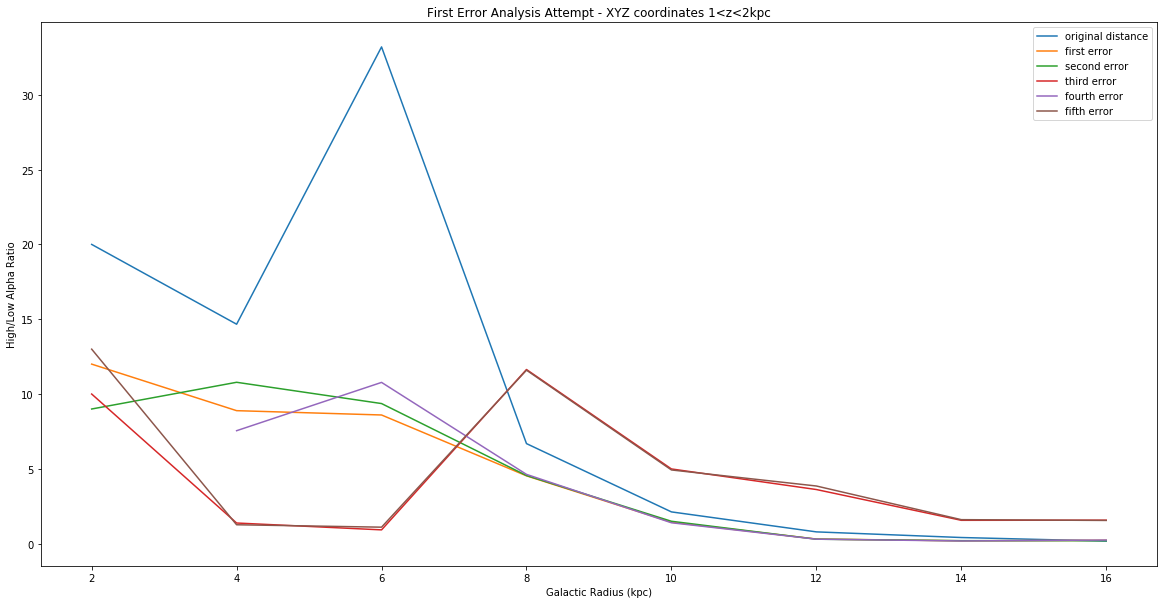

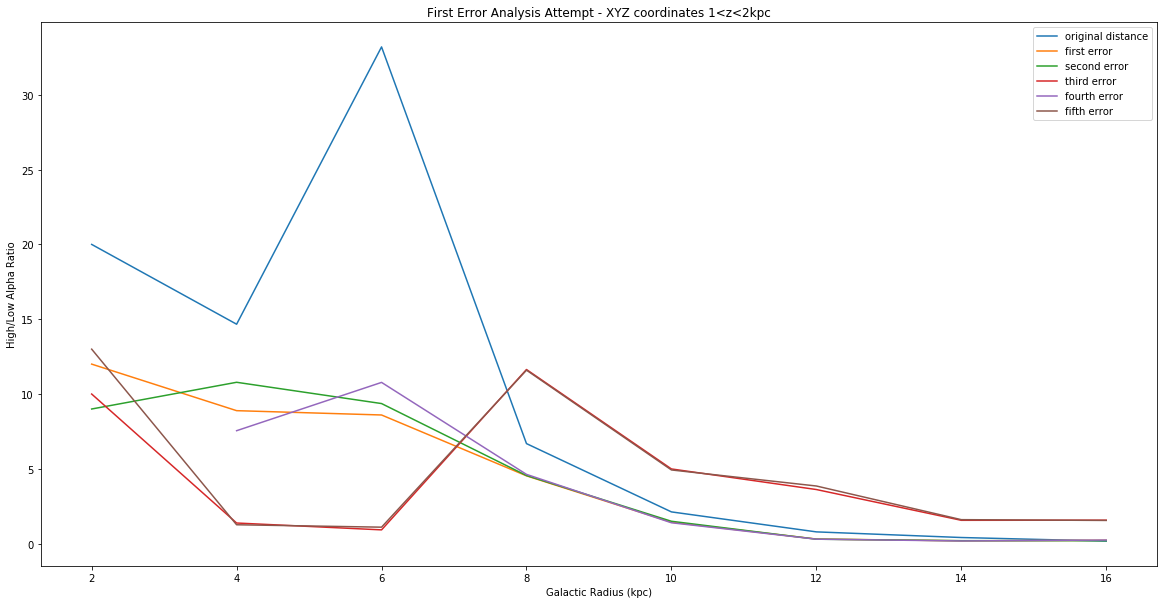

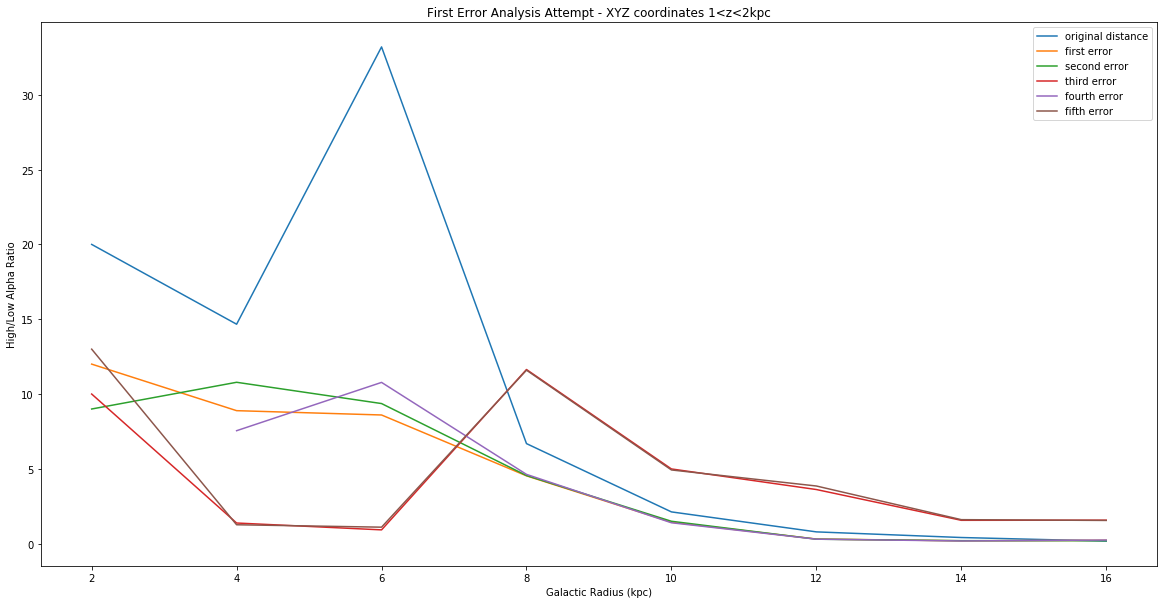

In [86]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.title('First Error Analysis Attempt - XYZ coordinates 1<z<2kpc')
plt.xlabel('Galactic Radius (kpc)')
plt.ylabel('High/Low Alpha Ratio')
xyzorigc = plt.plot(r, original_xyzratioc, label='original distance')
xyztry1c = plt.plot(r, try1_xyzratioc, label='first error')
xyztry2c = plt.plot(r, try2_xyzratioc, label='second error')
xyztry3c = plt.plot(r, try3_xyzratioc, label='third error')
xyztry4c = plt.plot(r, try4_xyzratioc, label='fourth error')
xyztry5c = plt.plot(r, try5_xyzratioc, label='fifth error')
plt.legend()
plt.show()

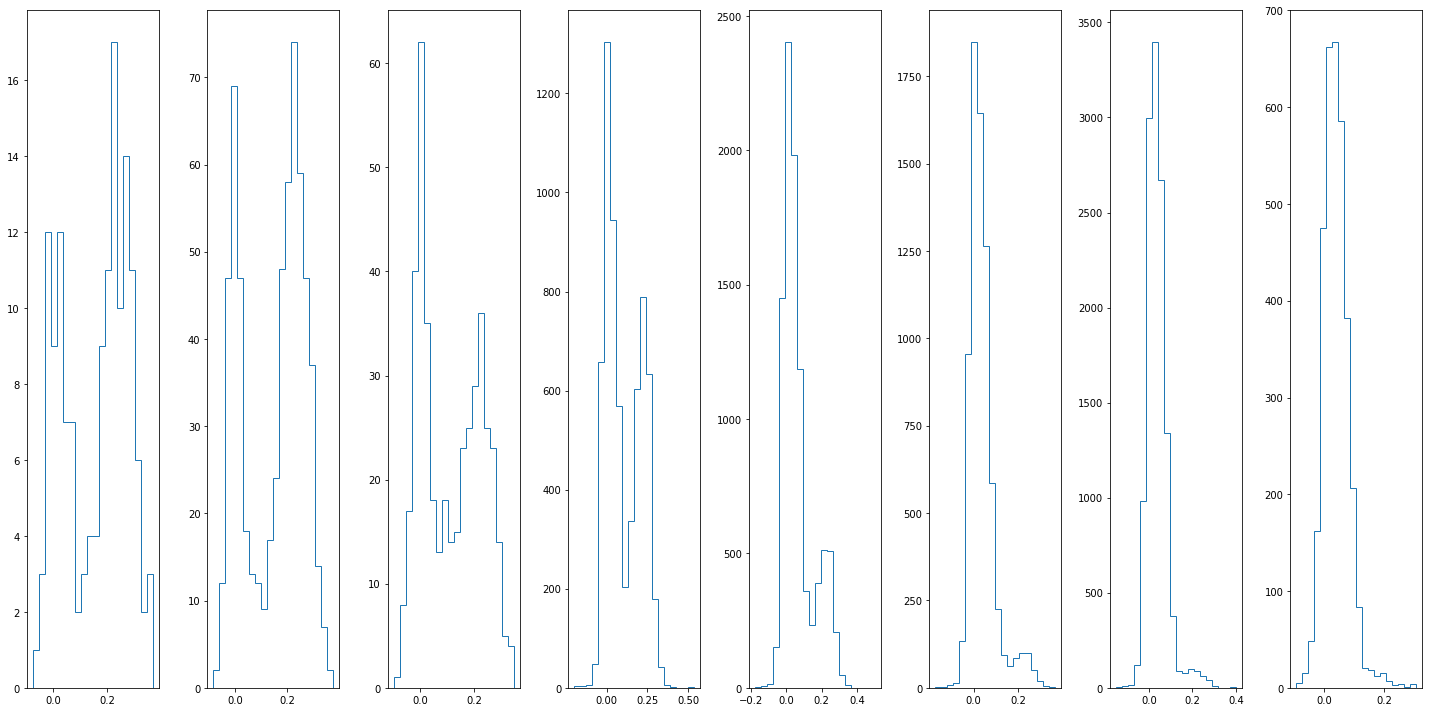

In [87]:
fig1 = plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,8,1)
T1AM1 = ax1.hist(T1A1, bins=20, histtype='step')
ax2 = plt.subplot(1,8,2)
T1AM2 = ax2.hist(T1A2, bins=20, histtype='step')
ax3 = plt.subplot(1,8,3)
T1AM3 = ax3.hist(T1A3, bins=20, histtype='step')
ax4 = plt.subplot(1,8,4)
T1AM4 = ax4.hist(T1A4, bins=20, histtype='step')
ax5 = plt.subplot(1,8,5)
T1AM5 = ax5.hist(T1A5, bins=20, histtype='step')
ax6 = plt.subplot(1,8,6)
T1AM6 = ax6.hist(T1A6, bins=20, histtype='step')
ax7 = plt.subplot(1,8,7)
T1AM7 = ax7.hist(T1A7, bins=20, histtype='step')
ax8 = plt.subplot(1,8,8)
T1AM8 = ax8.hist(T1A8, bins=20, histtype='step')
plt.tight_layout()
plt.show(fig1)

In [ ]:
x = np.linspace(a, b, 25)
y = np.array(t[1])
y.shape

In [ ]:
x = np.linspace(a, b, 1000)